# Space Analysis Demonstration

We are currently in the process of testing a strategy for capturing shelf space data and would like to use the growing dataset to better understand the time required to collect the data and perform some preliminary analyses of the data. Some questions that we would like to ask of this dataset include: 

* How many shelves can be measured per hour
* How much shelf space is taken up by each (LC subject level) range in the dataset
* How much shelf space is available within each range in the dataset

In support of answering these questions we need to do the following:

* Import the data into the script for analysis
* Aggregate the data by hour and count the number of shelves that were measured in each hour
* Aggregate the occupied space for all of the shelves for each range
* Calculate the total shelf space for each range

## 1. Import the data for the analysis

Importing the data for the analysis includes the following sub-tasks:

* Point to the local data file that containes the values that we want to analyze
* Create a file-like object from which we can read the data
* Read the data into a variable that we can use in our analyses

In [2]:
# Import a very useful and powerful module for interacting with tabular data
import pandas as pd

# Install and import tabulate for generating tables for hardcopy reports
!TABULATE_INSTALL=lib-only; pip install tabulate
from tabulate import tabulate

# Set up the report generation variables
report_file_name = 'report.md'
report_content = []
print("The generated report will be: " + report_file_name)

print("The version of pandas is: " + pd.__version__)

# Define the location of the file of interest
file_path = ""      # include a trailing "/" if not empty
file_name = "Space_Analysis_Pilot_(Responses).csv"
file_location = file_path + file_name
print("The file that will be read is: " + file_location)

# explicitly define the column names that will be associated with our table - this helps mitigate any
# strangeness in the column names in the source CSV file
column_names=[
    "timestamp", 
    "building", 
    "floor", 
    "range", 
    "section", 
    "shelf",
    "leading_alpha", 
    "leading_numeric",
    "ending_alpha",
    "ending_numeric",
    "occupied_in",
    "stacked"
]

# Load the referenced file into a pandas dataframe for use in our analysis
shelf_data = pd.read_csv(
    file_location,
    names = column_names,
    header = 0,
    usecols = ['timestamp','leading_alpha','ending_alpha','occupied_in'],
    skipinitialspace = True
)

# create a series of datatime values from the timestamps in the dataframe
# attempt to coerce error generating values, if can't set value to NaT (missing)
shelf_data['datetime'] = pd.to_datetime(shelf_data.loc[:,"timestamp"], errors='coerce')

# fill the NA values in the leading and ending alpha fields with a symbol
shelf_data.leading_alpha = shelf_data.leading_alpha.fillna('*')
shelf_data.ending_alpha = shelf_data.ending_alpha.fillna('*')
shelf_data.occupied_in.loc[(shelf_data.leading_alpha == "*")] = 0


# drop the rows that are missing leading_alpha values
shelf_data = shelf_data.loc[shelf_data.leading_alpha.notnull()]

# strip any leading or trailing white space from the alpha fields
shelf_data.leading_alpha.astype(str)
shelf_data['leading_alpha'] = shelf_data.leading_alpha.str.strip()
shelf_data['ending_alpha'] = shelf_data.ending_alpha.str.strip()

# generate columns with alpha prefixes for higher-level grouping
shelf_data['leading_prefix'] = shelf_data.leading_alpha.str[0]
shelf_data['ending_prefix'] = shelf_data.ending_alpha.str[0]

# add shelf capacity to each row in the table
shelf_data['capacity'] = 35.5

print("\nThe data types in the table are:\n"+str(shelf_data.dtypes))
print()
#print(shelf_data)

The generated report will be: report.md
The version of pandas is: 1.1.3
The file that will be read is: Space_Analysis_Pilot_(Responses).csv

The data types in the table are:
timestamp                 object
leading_alpha             object
ending_alpha              object
occupied_in              float64
datetime          datetime64[ns]
leading_prefix            object
ending_prefix             object
capacity                 float64
dtype: object



/Users/kbene/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## 2. Aggregate the data by hour and count the shelves for each hour

The following sub-tasks are required for this part of our analysis

* Create a new column in the dataframe that contains a distinct value for each hour in the database
* Group the individual shelves by hour label
* Count the shelves for each hour
* Plot the number of shelves per hour for the analysis period
 

In [3]:
# create a dataframe that has a subset of rows that only contain valid datetime values
clean_dates = shelf_data[shelf_data.datetime.notnull()]
clean_dates = clean_dates.set_index('datetime')
#clean_dates['hour'] = clean_dates['datetime'].strftime('%Y-%M-%d %H')

clean_dates

# resample the timestamps by hour and return the frequency distribution
r = clean_dates.resample("1H")

r_count = r.count() # .loc[(r_count.timestamp > 0)]

r_count.timestamp

datetime
2017-05-22 17:00:00    111
2017-05-22 18:00:00      1
2017-05-22 19:00:00      0
2017-05-22 20:00:00      0
2017-05-22 21:00:00      0
                      ... 
2017-06-01 13:00:00      0
2017-06-01 14:00:00      0
2017-06-01 15:00:00      0
2017-06-01 16:00:00      0
2017-06-01 17:00:00     14
Freq: H, Name: timestamp, Length: 241, dtype: int64

<AxesSubplot:xlabel='datetime'>

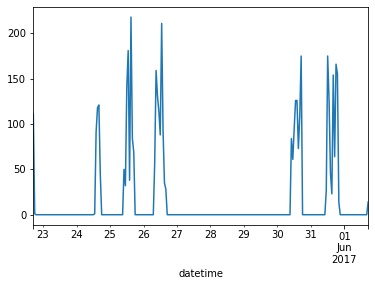

In [4]:
r_count['timestamp'].plot()

## 3. Aggregate the occupied space for all of the shelves for each range

The following sub-tasks are required for this part of our analysis:

* Total the occupied space for all of the whole shelves - i.e. those where the start and end range alpha values are the same
* Estimate the occupied space for all of the partial shelves
* Add these numbers up  for an estimate of the total occupied space for each range

In [5]:
full_shelves = shelf_data.loc[(shelf_data.leading_alpha == shelf_data.ending_alpha)]
partial_shelves = shelf_data.loc[(shelf_data.leading_alpha != shelf_data.ending_alpha)].loc[(shelf_data.leading_alpha.notnull())]

# convert our column to numeric values instead of the string type it defaulted to - adding strings is not 
# what we want to do. Partial shelves are arbitrarily assigned half of the occupied value and the capacity. 
pd.to_numeric(full_shelves['occupied_in'], errors="coerce")
partial_shelves['partial_occupied_in'] = pd.to_numeric(partial_shelves['occupied_in'], errors="coerce") / 2
partial_shelves['partial_capacity'] = pd.to_numeric(partial_shelves['capacity'], errors="coerce") / 2


#print(full_shelves[['leading_alpha','ending_alpha','occupied_in','capacity']])
#print(partial_shelves[['leading_alpha','ending_alpha','partial_occupied_in','partial_capacity']])

## 4. Calculate occupied and total shelf space for each LC subject

For this we need to:

* Group the individual shelf data by LC subject categories
* Calculate the occupied and total capacity for each group
* Calculate some derived values for reporting

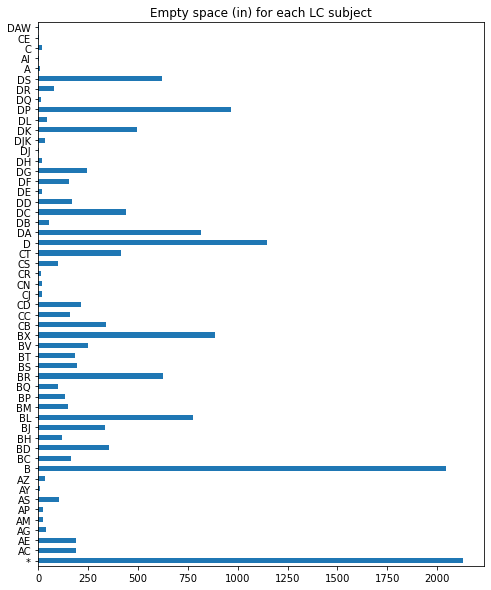

In [7]:
# import a useful library for doing calculations on arrays - including our data table and its columns
import numpy as np

# group our full and partial shelves by the leading_alpha subject string
full_shelves_by_range = full_shelves.groupby('leading_alpha')
partial_shelves_by_range = partial_shelves.groupby('leading_alpha')

# calculate the sum for all of the numeric columns for our full and partial shelves
full_ranges = full_shelves_by_range.aggregate(np.sum)
partial_ranges = partial_shelves_by_range.aggregate(np.sum)

# calculate some new columns of data for each range
combined_by_lc = pd.concat([full_ranges,partial_ranges], axis=1)
combined_by_lc['total_occupied_in'] = combined_by_lc[['occupied_in','partial_occupied_in']].sum(axis=1)
combined_by_lc['total_capacity_in'] = combined_by_lc[['capacity','partial_capacity']].sum(axis=1)
combined_by_lc['total_empty_in'] = combined_by_lc['total_capacity_in'] - combined_by_lc['total_occupied_in']
combined_by_lc['total_empty_pct'] =  100 * (1-combined_by_lc['total_occupied_in'] / combined_by_lc['total_capacity_in'])

# now let's generate some plots for fun

lc_plot = combined_by_lc['total_empty_in'].plot(kind="barh",stacked=False,figsize=(8,10), title="Empty space (in) for each LC subject")
lc_fig = lc_plot.get_figure()
lc_fig.savefig("lc_fig.png")

report_content.append("""
![Empty Space (in) for each LC subject](lc_fig.png)

""")

# cumulative = combined_by_lc[['total_occupied_in','total_capacity_in','total_empty_in']].cumsum()
# print(cumulative)

#cumulative.plot(kind="barh",stacked=True,figsize={8,10})

## 5. Repeat the above range-level analyses for the full top-level LC subject category prefixes

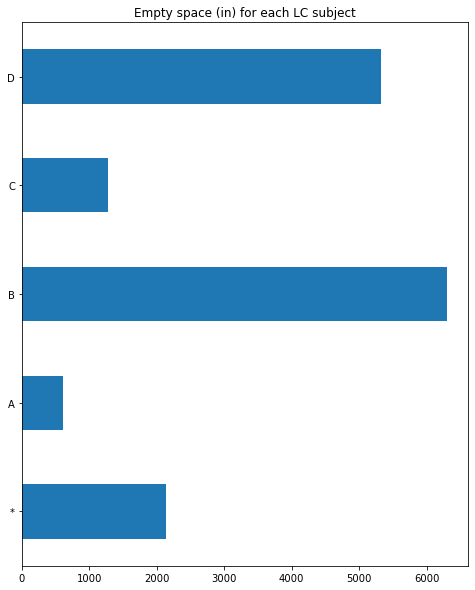

In [8]:
prefix_full_shelves = shelf_data.loc[(shelf_data.leading_prefix == shelf_data.ending_prefix)]
prefix_partial_shelves = shelf_data.loc[(shelf_data.leading_prefix != shelf_data.ending_prefix)].loc[(shelf_data.leading_prefix.notnull())]

# convert our column to numeric values instead of the string type it defaulted to - adding strings is not 
# what we want to do. Partial shelves are arbitrarily assigned half of the occupied value and the capacity. 
pd.to_numeric(prefix_full_shelves['occupied_in'], errors="coerce")
prefix_partial_shelves['partial_occupied_in'] = pd.to_numeric(prefix_partial_shelves['occupied_in'], errors="coerce") / 2
prefix_partial_shelves['partial_capacity'] = pd.to_numeric(prefix_partial_shelves['capacity'], errors="coerce") / 2


#print(full_shelves[['leading_prefix','ending_prefix','occupied_in','capacity']])
#print(partial_shelves[['leading_prefix','ending_prefix','partial_occupied_in','partial_capacity']])

# import a useful library for doing calculations on arrays - including our data table and its columns
import numpy as np

# group our full and partial shelves by the leading_alpha subject string
prefix_full_shelves_by_range = prefix_full_shelves.groupby('leading_prefix')
prefix_partial_shelves_by_range = prefix_partial_shelves.groupby('leading_prefix')

# calculate the sum for all of the numeric columns for our full and partial shelves
prefix_full_ranges = prefix_full_shelves_by_range.aggregate(np.sum)
prefix_partial_ranges = prefix_partial_shelves_by_range.aggregate(np.sum)

# calculate some new columns of data for each range
prefix_combined_by_lc = pd.concat([prefix_full_ranges,prefix_partial_ranges], axis=1)
prefix_combined_by_lc['total_occupied_in'] = prefix_combined_by_lc[['occupied_in','partial_occupied_in']].sum(axis=1)
prefix_combined_by_lc['total_capacity_in'] = prefix_combined_by_lc[['capacity','partial_capacity']].sum(axis=1)
prefix_combined_by_lc['total_empty_in'] = prefix_combined_by_lc['total_capacity_in'] - prefix_combined_by_lc['total_occupied_in']
prefix_combined_by_lc['total_empty_pct'] =  100 * (1-prefix_combined_by_lc['total_occupied_in'] / prefix_combined_by_lc['total_capacity_in'])

# now let's generate some plots for fun

prefix_plot = prefix_combined_by_lc['total_empty_in'].plot(kind="barh",stacked=False,figsize=(8,10), title="Empty space (in) for each LC subject")
prefix_fig = prefix_plot.get_figure()
prefix_fig.savefig("prefix_fig.png")

report_content.append("""
![Empty Space (in) for each LC subject prefix](prefix_fig.png)

""")



# prefix_cumulative = prefix_combined_by_lc[['total_occupied_in','total_capacity_in','total_empty_in']].cumsum()
# print(cumulative)

#cumulative.plot(kind="barh",stacked=True,figsize={8,10})

## Generate a report with the results

In [9]:
report_content.append("""
# UNM College of University Libraries and Learning Sciences Shelf Space Analysis

This is where some intro text will go ...
""")

# calculate some overall totals for all LC subjects
prefix_grand_total_capacity_in = prefix_combined_by_lc['total_capacity_in'].sum()
prefix_grand_total_occupied_in = prefix_combined_by_lc['total_occupied_in'].sum()
prefix_grand_total_empty_in = prefix_combined_by_lc['total_empty_in'].sum()
prefix_grand_total_empty_pct = 100 * (prefix_grand_total_empty_in / prefix_grand_total_capacity_in)

# print out the generated information
print("For Library of Congress Subject Prefixes")
print("\tTotal Capacity (in): " + str(prefix_grand_total_capacity_in))
print("\tTotal Occupied (in): " + str(prefix_grand_total_occupied_in))
print("\tTotal Empty Space (in): " + str(prefix_grand_total_empty_in))
print("\tTotal Empty Space (pct): " + str(prefix_grand_total_empty_pct))
print()

# write the information into the report
report_content.append("""
## Summary information for LC subject prefixes

Total Capacity (in): %s\\
Total Occupied (in): %s\\
Total Empty Space (in): %s\\
Total Empty Space (pct): %s\\

"""%(
        prefix_grand_total_capacity_in,
        prefix_grand_total_occupied_in,
        prefix_grand_total_empty_in,
        prefix_grand_total_empty_pct
    ) 
)

# calculate some overall totals for all LC subjects
grand_total_capacity_in = combined_by_lc['total_capacity_in'].sum()
grand_total_occupied_in = combined_by_lc['total_occupied_in'].sum()
grand_total_empty_in = combined_by_lc['total_empty_in'].sum()
grand_total_empty_pct = 100 * (grand_total_empty_in / grand_total_capacity_in)

# print out the generated information
print("For Library of Congress Subjects")
print("\tTotal Capacity (in): " + str(grand_total_capacity_in))
print("\tTotal Occupied (in): " + str(grand_total_occupied_in))
print("\tTotal Empty Space (in): " + str(grand_total_empty_in))
print("\tTotal Empty Space (pct): " + str(grand_total_empty_pct))
print()

# write the information into the report
report_content.append("""
## Summary information for LC subjects

Total Capacity (in): %s\\
Total Occupied (in): %s\\
Total Empty Space (in): %s\\
Total Empty Space (pct): %s\\

"""%(
        grand_total_capacity_in,
        grand_total_occupied_in,
        grand_total_empty_in,
        grand_total_empty_pct
    ) 
)


For Library of Congress Subject Prefixes
	Total Capacity (in): 144786.75
	Total Occupied (in): 129149.0
	Total Empty Space (in): 15637.75
	Total Empty Space (pct): 10.800539414000246

For Library of Congress Subjects
	Total Capacity (in): 145532.25
	Total Occupied (in): 129815.5
	Total Empty Space (in): 15716.75
	Total Empty Space (pct): 10.79949633156912



In [10]:
# generate some tables for the report
prefix_table = tabulate(prefix_combined_by_lc[['total_occupied_in','total_capacity_in','total_empty_in', 'total_empty_pct']], headers=["Occupied (in)","Capacity (in)","Empty (in)","Empty (pct)"])
subject_table = tabulate(combined_by_lc[['total_occupied_in','total_capacity_in','total_empty_in', 'total_empty_pct']], headers=["Occupied (in)","Capacity (in)","Empty (in)","Empty (pct)"])

report_content.append("""
## Summary Tables

%s

Table: LC Prefix Space Summary Table

%s

Table: LC Subject Space Summary Table


"""%(prefix_table, subject_table))


print(prefix_table)
print(subject_table)

      Occupied (in)    Capacity (in)    Empty (in)    Empty (pct)
--  ---------------  ---------------  ------------  -------------
*                 0          2130          2130         100
A              4220          4828           608          12.5932
B             57100         63403          6303           9.94117
C              8464          9744.75       1280.75       13.143
D             59365         64681          5316           8.2188
       Occupied (in)    Capacity (in)    Empty (in)    Empty (pct)
---  ---------------  ---------------  ------------  -------------
*                0            2130          2130         100
AC            1214.5          1402.25        187.75       13.3892
AE            1231            1420           189          13.3099
AG             331.5           372.75         41.25       11.0664
AM             366             390.5          24.5         6.27401
AP             207.5           230.75         23.25       10.0758
AS             621    

In [232]:
# generate the report

with open(report_file_name,"w") as f:
    for block in report_content:
        f.write(block)

pandoc_options = "-o %s.pdf %s"%(report_file_name,report_file_name)
        
import subprocess
subprocess.run(['pandoc', "-o %s.pdf"%(report_file_name), report_file_name])

CompletedProcess(args=['pandoc', '-o report.md.pdf', 'report.md'], returncode=0)